In [1]:
# Package Imports - feel free to add what you think might be useful! 
# %pip install numpy
# %pip install matplotlib

import numpy as np 
import matplotlib.pyplot as plt 

## Task 1: Playing with Pseudo-Randomness

### Part A: Implement and Benchmark an LCG

In [4]:
def Linear_Congruential_Generator(seed, multiplier, increment, modulus, num_samples):
    sequence = []
    x = seed
    for _ in range(num_samples):
        x = (multiplier * x + increment) % modulus
        sequence.append(x / modulus)  # Normalize to [0,1)
    return sequence

In [2]:

# Parameters satisfying Hull-Dobell Theorem
# Let's choose m = 2^32 (divisible by 4), a = 1664525 (a-1 divisible by 4), c = 1013904223 (coprime with m)
seed = 12345
multiplier = 1664525
increment = 1013904223
modulus = 2**32
num_samples = 10**6

In [4]:
# Generate sequence
lcg_sequence = Linear_Congruential_Generator(seed, multiplier, increment, modulus, num_samples)

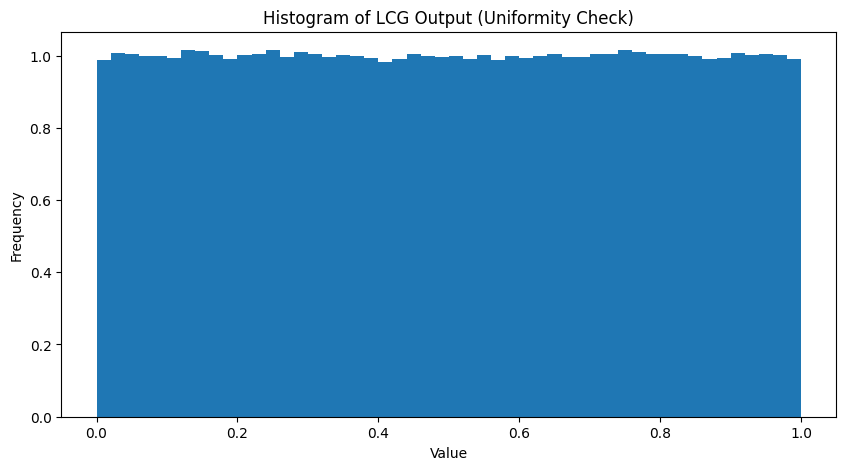

In [5]:
# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(lcg_sequence, bins=50, density=True)
plt.title('Histogram of LCG Output (Uniformity Check)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [5]:
# Compute and plot entropy over time
def compute_entropy(data, window_size=1000):
    entropy_values = []
    for i in range(window_size, len(data), window_size):
        window = data[i-window_size:i]
        counts = np.histogram(window, bins=50, range=(0,1))[0]
        probs = counts / window_size
        probs = probs[probs > 0]  # Avoid log(0)
        shannon_entropy = -np.sum(probs * np.log2(probs))
        entropy_values.append(shannon_entropy)
    return entropy_values

In [ ]:
""" 
1. fix a short seed value for each LCG 
(no more than 2^10 possible values for the seed)

2. Over a long LCG sequence (at least 10^6 samples),
as the generator produces values, treat the sequence of outputs 
up to each step as a growing empirical distribution.

3. At regular intervals (e.g., every 1000 iterations), 
compute the Shannon Entropy or Min-Entropy 
of the current sample distribution.

Hint: We've already imported matplotlib for you, 
though any plotting package will do the trick.
"""
pass # TOD: Plot how the Shannon Entropy or Min-Entropy evolves with the number of iterations for each LCG configuration.

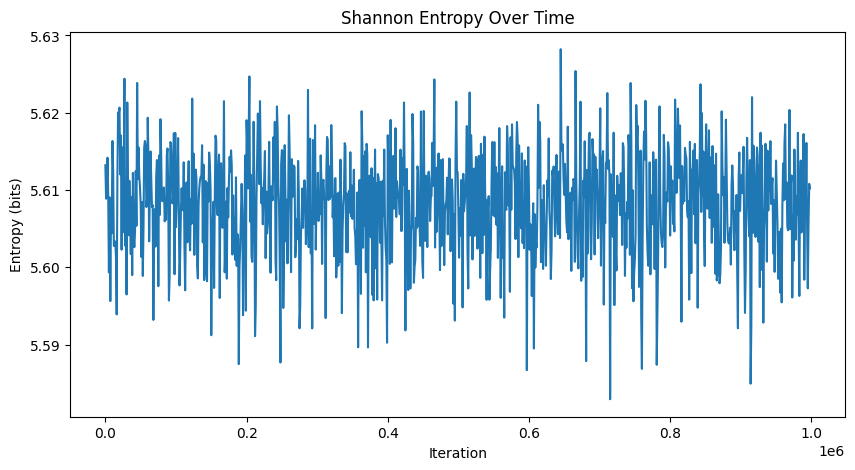

In [7]:
entropy_vals = compute_entropy(lcg_sequence)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(entropy_vals)) * 1000, entropy_vals)
plt.title('Shannon Entropy Over Time')
plt.xlabel('Iteration')
plt.ylabel('Entropy (bits)')
plt.show()

### Part B: Implement and Benchmark AES-Based PRNGs

In [ ]:
# Here is a reference implementation of the AES algorithm: https://github.com/burakozpoyraz/Advanced-Encryption-Standard/tree/master

In [6]:
from Crypto.Cipher import AES
import os

def pad_seed(seed_bytes, target_len=16):
    # Pad with zeros if too short, truncate if too long
    if len(seed_bytes) < target_len:
        return seed_bytes + bytes([0] * (target_len - len(seed_bytes)))
    return seed_bytes[:target_len]

def AES_PRNG(seed, num_bytes):
    cipher = AES.new(pad_seed(seed), AES.MODE_ECB)
    num_blocks = (num_bytes + 15) // 16  # Round up to nearest block
    random_bytes = b''
    counter = 0
    
    while len(random_bytes) < num_bytes:
        counter_bytes = counter.to_bytes(16, 'big')
        encrypted = cipher.encrypt(counter_bytes)
        random_bytes += encrypted
        counter += 1
    
    # Convert to float values in [0,1)
    int_vals = [int.from_bytes(random_bytes[i:i+4], 'big') for i in range(0, num_bytes, 4)]
    max_int = 2**32
    return [x / max_int for x in int_vals][:num_bytes//4]


In [ ]:
# TDO: choose at least 3 different seed lengths (e.g., 8, 16, 64 bits)
seed_lengths = [1, 2, 8]  # in bytes

# TDO: generate sequences of increasing length (10^5 to 10^7) for each seed length
sequence_lengths = [10**5, 10**6]

In [10]:
from tqdm import tqdm

In [11]:
# Example: Generate and store sequences
all_sequences = {}

for seed_len in seed_lengths:
    seed = np.random.bytes(seed_len)
    all_sequences[seed_len] = {}

    for seq_len in tqdm(sequence_lengths):
        prng_output = AES_PRNG(seed, seq_len)
        all_sequences[seed_len][seq_len] = prng_output

100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


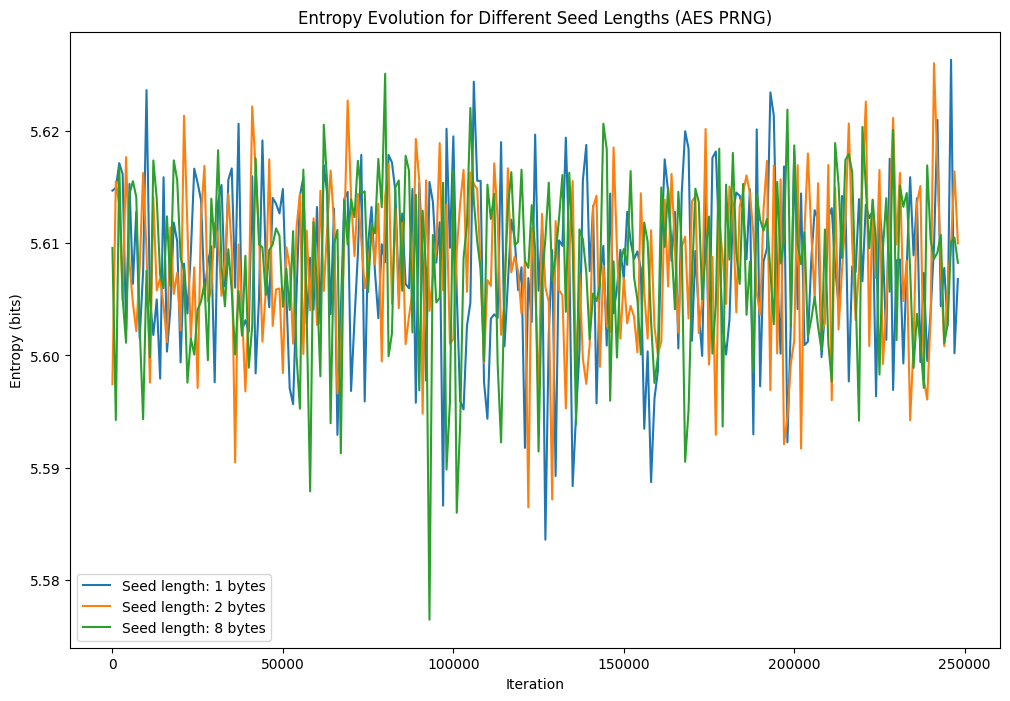

In [33]:
# Plot entropy evolution for different seed lengths
plt.figure(figsize=(12, 8))
for seed_len in seed_lengths:
    seq = all_sequences[seed_len][10**6]
    entropy_vals = compute_entropy(seq)
    plt.plot(np.arange(len(entropy_vals)) * 1000, entropy_vals, 
             label=f'Seed length: {seed_len} bytes')

plt.title('Entropy Evolution for Different Seed Lengths (AES PRNG)')
plt.xlabel('Iteration')
plt.ylabel('Entropy (bits)')
plt.legend()
plt.show()

In [34]:
# Plot autocorrelation
def plot_autocorrelation(sequence, max_lag=100):
    autocorrs = []
    mean = np.mean(sequence)
    var = np.var(sequence)
    
    for k in range(1, max_lag+1):
        cov = np.mean((sequence[:-k] - mean) * (sequence[k:] - mean))
        autocorrs.append(cov / var)
    
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, max_lag+1), autocorrs)
    plt.title('Autocorrelation vs Lag')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

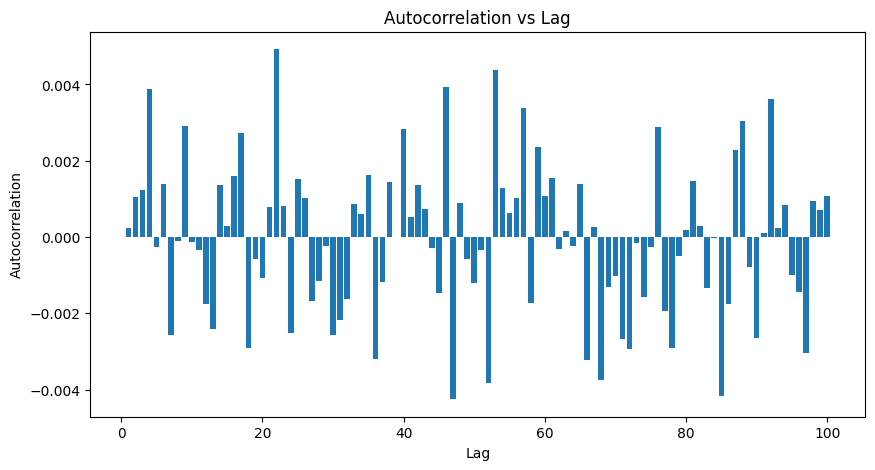

In [35]:
# Example for seed length 8
plot_autocorrelation(all_sequences[8][10**6])

In [37]:
from scipy import stats
# Statistical test (Chi-squared)
def run_statistical_tests(sequence, num_bins=50):
    observed, _ = np.histogram(sequence, bins=num_bins)
    expected = np.full(num_bins, len(sequence)/num_bins)
    chi2 = np.sum((observed - expected)**2 / expected)
    p_value = 1 - stats.chi2.cdf(chi2, num_bins-1)
    print(f"Chi-squared test: χ² = {chi2:.2f}, p-value = {p_value:.4f}")

run_statistical_tests(all_sequences[8][10**6])

Chi-squared test: χ² = 35.49, p-value = 0.9260


### (BONUS) Part C: Breaking the Illusion of Randomness

### Bonus Task:
Train a light-weight model (small-neural net or decision tree) to predict the next number in your random number sequences generated from LCG and AES. Now try implementing at least one other more robust PRNGs from the list below:
- XOR-Shift Generator
- Permuted Congruential Generator (PCG) 
- SplitMix64 

=== Testing LCG Predictability ===
Epoch 10/50 - Train Loss: 0.085082, Test Loss: 0.084767
Epoch 20/50 - Train Loss: 0.083719, Test Loss: 0.084340
Epoch 30/50 - Train Loss: 0.083040, Test Loss: 0.084145
Epoch 40/50 - Train Loss: 0.082876, Test Loss: 0.084334
Epoch 50/50 - Train Loss: 0.082825, Test Loss: 0.084130


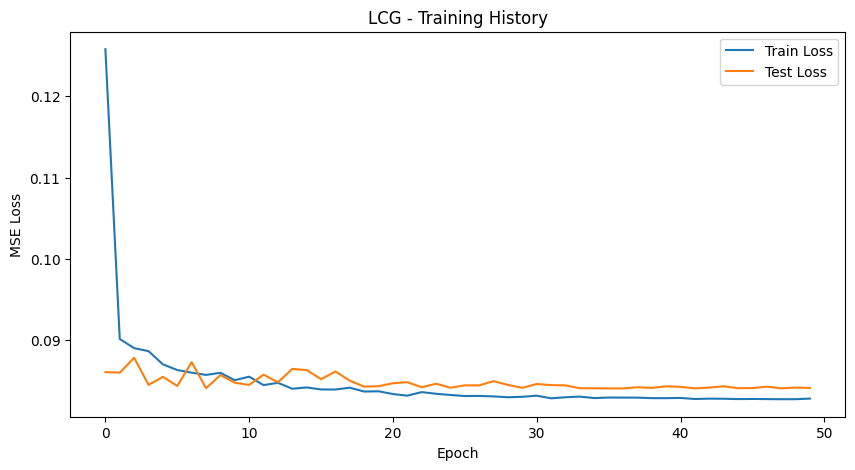


Final Test MSE for LCG: 0.084020


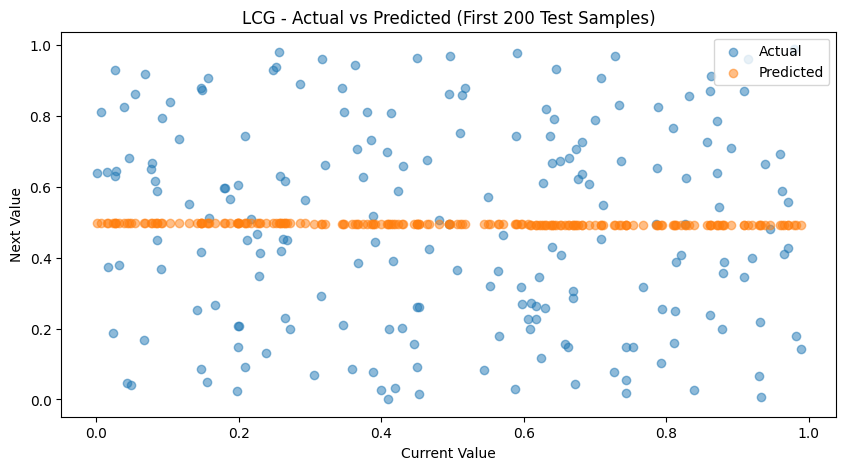


=== Testing AES PRNG Predictability ===
Epoch 10/50 - Train Loss: 0.087610, Test Loss: 0.081293
Epoch 20/50 - Train Loss: 0.084085, Test Loss: 0.081605
Epoch 30/50 - Train Loss: 0.083583, Test Loss: 0.081522
Epoch 40/50 - Train Loss: 0.082983, Test Loss: 0.081249
Epoch 50/50 - Train Loss: 0.082940, Test Loss: 0.081126


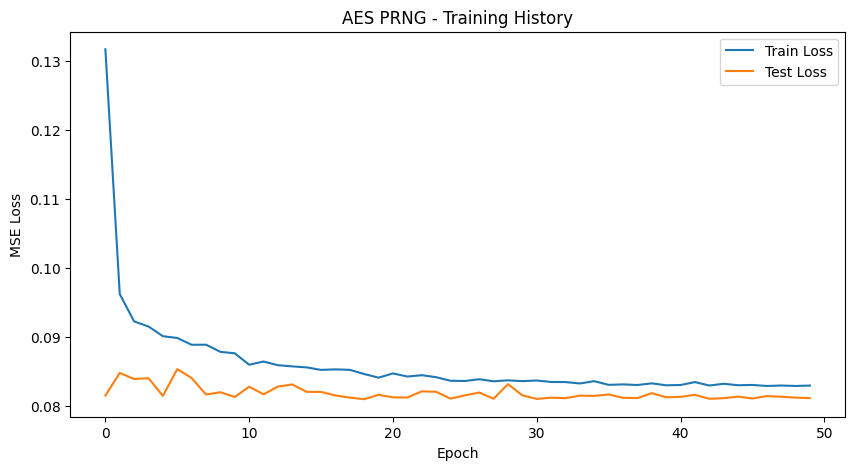


Final Test MSE for AES PRNG: 0.080827


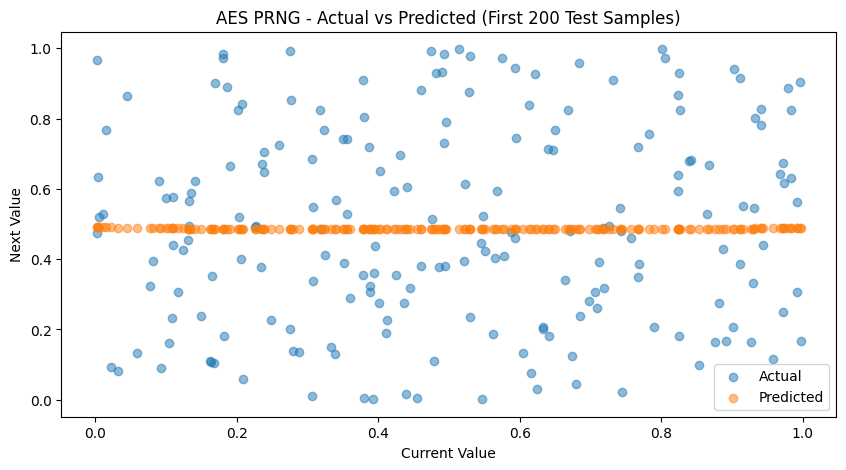


=== Comparative Results ===
LCG Test MSE: 0.084020
AES PRNG Test MSE: 0.080827


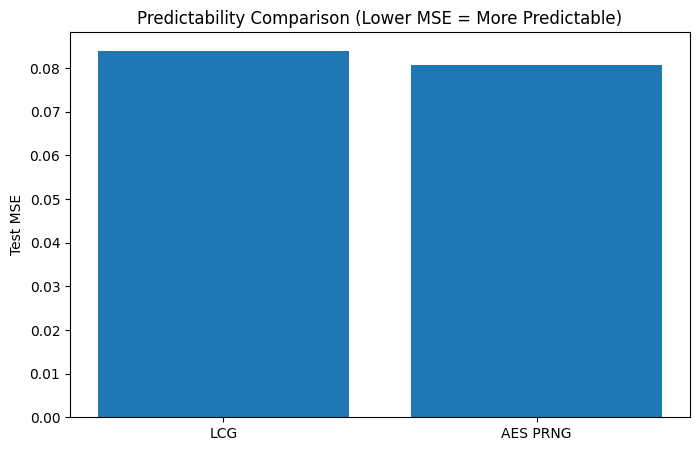

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from Crypto.Cipher import AES

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ===== PRNG Implementations =====
class LCG:
    def __init__(self, seed=12345):
        self.state = seed
        self.a = 1664525  # multiplier
        self.c = 1013904223  # increment
        self.m = 2**32  # modulus
    
    def next_float(self):
        self.state = (self.a * self.state + self.c) % self.m
        return self.state / self.m
    
    def generate(self, n):
        return [self.next_float() for _ in range(n)]

class AES_PRNG:
    def __init__(self, seed=b"test_seed"):
        self.seed = seed.ljust(16, b'\0')[:16]  # Pad/truncate to 16 bytes
        self.counter = 0
    
    def next_float(self):
        cipher = AES.new(self.seed, AES.MODE_ECB)
        counter_block = self.counter.to_bytes(16, 'big')
        encrypted = cipher.encrypt(counter_block)
        self.counter += 1
        return int.from_bytes(encrypted[:4], 'big') / 2**32
    
    def generate(self, n):
        return [self.next_float() for _ in range(n)]

# ===== Neural Network Predictor =====
class PRNGPredictor(nn.Module):
    def __init__(self):
        super(PRNGPredictor, self).__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

def train_and_evaluate(sequence, name, epochs=50):
    # Prepare data
    X = np.array(sequence[:-1], dtype=np.float32).reshape(-1, 1)
    y = np.array(sequence[1:], dtype=np.float32).reshape(-1, 1)
    
    # Split into train and test
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    
    # Convert to PyTorch tensors
    train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
    
    # Create dataloaders
    batch_size = 64
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    
    # Initialize model, loss, and optimizer
    model = PRNGPredictor()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                test_loss += criterion(outputs, targets).item()
        
        test_loss = test_loss / len(test_loader)
        test_losses.append(test_loss)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'{name} - Training History')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        test_preds = model(torch.from_numpy(X_test)).numpy()
    
    test_mse = mean_squared_error(y_test, test_preds)
    print(f'\nFinal Test MSE for {name}: {test_mse:.6f}')
    
    # Plot predictions vs actual
    plt.figure(figsize=(10, 5))
    plt.scatter(X_test[:200], y_test[:200], alpha=0.5, label='Actual')
    plt.scatter(X_test[:200], test_preds[:200], alpha=0.5, label='Predicted')
    plt.title(f'{name} - Actual vs Predicted (First 200 Test Samples)')
    plt.xlabel('Current Value')
    plt.ylabel('Next Value')
    plt.legend()
    plt.show()
    
    return test_mse

# ===== Main Execution =====
if __name__ == "__main__":
    # Generate sequences
    lcg = LCG()
    lcg_sequence = lcg.generate(10000)
    
    aes_prng = AES_PRNG()
    aes_sequence = aes_prng.generate(10000)
    
    # Train and evaluate models
    print("=== Testing LCG Predictability ===")
    lcg_mse = train_and_evaluate(lcg_sequence, "LCG")
    
    print("\n=== Testing AES PRNG Predictability ===")
    aes_mse = train_and_evaluate(aes_sequence, "AES PRNG")
    
    # Comparative results
    print("\n=== Comparative Results ===")
    print(f"LCG Test MSE: {lcg_mse:.6f}")
    print(f"AES PRNG Test MSE: {aes_mse:.6f}")
    
    # Plot comparison
    plt.figure(figsize=(8, 5))
    plt.bar(['LCG', 'AES PRNG'], [lcg_mse, aes_mse])
    plt.title('Predictability Comparison (Lower MSE = More Predictable)')
    plt.ylabel('Test MSE')
    plt.show()


Testing XORShift128 with 100,000 samples...
Chi-squared test: 92.07 (lower is better, expected ~100)
Serial correlation: 0.000945 (closer to 0 is better)
Shannon entropy: 7.9984/8.0 bits
π estimate: 3.141760 (error: 0.000167)


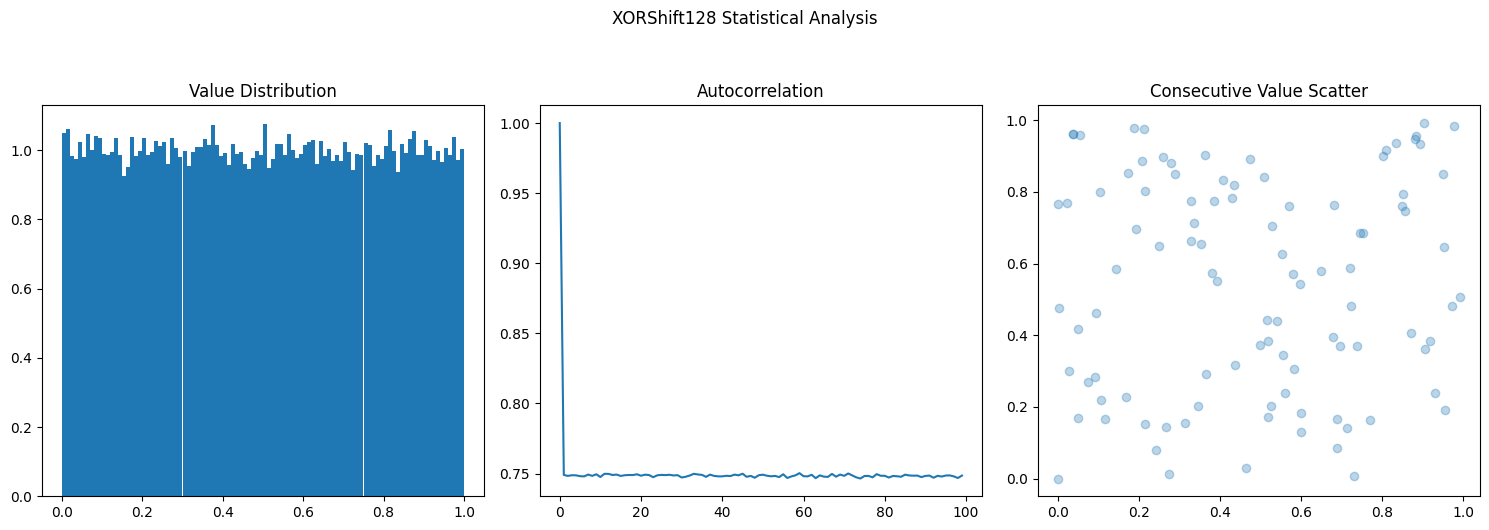

{'name': 'XORShift128',
 'chi2': 92.06800000000001,
 'correlation': 0.0009447066891285691,
 'entropy': 7.998412415336956,
 'pi_error': 0.00016734641020699215}

In [50]:
class XORShift128:
    def __init__(self, seed=1):
        self.state = [seed] * 4  # Initialize with 4 values
        # Ensure state isn't all zeros
        if all(x == 0 for x in self.state):
            self.state = [0x12345678, 0x87654321, 0xABCDEF01, 0x10FEDCBA]
    
    def next_int(self):
        t = self.state[3]
        s = self.state[0]
        self.state[3] = self.state[2]
        self.state[2] = self.state[1]
        self.state[1] = s
        
        t ^= (t << 11) & 0xFFFFFFFFFFFFFFFF
        t ^= (t >> 8)
        t ^= (s ^ (s >> 19)) & 0xFFFFFFFFFFFFFFFF
        self.state[0] = t
        return t
    
    def next_float(self):
        return self.next_int() / 2**64
    
    def generate(self, n):
        return [self.next_float() for _ in range(n)]
    
# Benchmarking and Analysis Functions
def run_statistical_tests(generator, name, num_samples=10**6):
    print(f"\nTesting {name} with {num_samples:,} samples...")

    # Convert to numpy array
    samples = generator.generate(num_samples)
    samples = np.array(samples)
    
    # 1. Uniformity test (chi-squared)
    hist, _ = np.histogram(samples, bins=100, range=(0,1))
    expected = len(samples)/100
    chi2 = np.sum((hist - expected)**2 / expected)
    print(f"Chi-squared test: {chi2:.2f} (lower is better, expected ~100)")
    
    # 2. Serial correlation
    corr = np.corrcoef(samples[:-1], samples[1:])[0,1]
    print(f"Serial correlation: {corr:.6f} (closer to 0 is better)")
    
    # 3. Shannon entropy
    hist, _ = np.histogram(samples, bins=256, range=(0,1))
    probs = hist / len(samples)
    probs = probs[probs > 0]  # Avoid log(0)
    shannon_entropy = -np.sum(probs * np.log2(probs))
    print(f"Shannon entropy: {shannon_entropy:.4f}/8.0 bits")
    
    # 4. Monte Carlo π estimation
    in_circle = np.sum(samples[::2]**2 + samples[1::2]**2 <= 1)
    pi_est = 4 * in_circle / (len(samples)//2)
    print(f"π estimate: {pi_est:.6f} (error: {abs(pi_est - np.pi):.6f})")
    
    # Visualization
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"{name} Statistical Analysis", y=1.05)
    
    # Distribution plot
    plt.subplot(1, 3, 1)
    plt.hist(samples, bins=100, density=True)
    plt.title("Value Distribution")
    
    # Autocorrelation plot
    plt.subplot(1, 3, 2)
    autocorr = np.correlate(samples, samples, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    autocorr = autocorr / autocorr[0]
    plt.plot(autocorr[:100])
    plt.title("Autocorrelation")
    
    # Scatter plot
    plt.subplot(1, 3, 3)
    plt.scatter(samples[:-1:1000], samples[1::1000], alpha=0.3)
    plt.title("Consecutive Value Scatter")
    
    plt.tight_layout()
    plt.show()
    
    return {
        "name": name,
        "chi2": chi2,
        "correlation": corr,
        "entropy": shannon_entropy,
        "pi_error": abs(pi_est - np.pi)
    }

# Run the comprehensive comparison
run_statistical_tests(XORShift128(seed=12345),"XORShift128", 10**5)